In [56]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [57]:
import sys
TRAIN = True
TRAIN_MODEL_3 = False
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [58]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [59]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [60]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams

training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)


assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /root/artem/work


# loss: 0.03

# Imports

In [61]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2.5.0


/tmp/ipykernel_2581208/3340962001.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [62]:
print('training_reports_path=', training_reports_path)

training_reports_path= /root/artem/analyser/training_reports


In [63]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

for device in gpu_devices:
    print(device)
#     tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Prepare trainset


In [64]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [65]:
if False:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

work_dir = Path(analyser.hyperparams.work_dir)
print(work_dir)

/root/artem/work


In [66]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx = xx[ (xx.version=='3.0.0') | (xx.version=='22.12.7')].sort_values(['score'])
# xx.to_csv('contracts_to_re-analyze.csv')
# xx

In [67]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx['user_correction_date'] = pd.to_datetime(xx['user_correction_date'], utc=True)


# xx['user_correction_date'] = xx['user_correction_date'].astype('datetime64[ns]')


# xx.to_datetime(df_res['DateTime'], utc=True)

# xx['user_correction_date'] = xx['user_correction_date'].dt.tz_localize(None)

# xx.sort_values(['user_correction_date'])

In [68]:
# yy = xx.sort_values(['user_correction_date'])[xx.version!='22.12.7'][xx.source=='db'].sort_values(['score'])
# yy

In [69]:
# stats['user_correction_date'] = stats['user_correction_date'].dt.tz_localize(None)
# stats.sort_values(['user_correction_date'])

In [70]:
# yy.to_csv('contracts_to_review.csv')

In [71]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
stats

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,valid,documentType,url,unseen,score,hash,dups,subj_len,subject_weight,sample_weight
_id,,,,,,,,,,,,,,,,,,,,,
6346a561172785f510f15e2a,db,1439eb4d76211bd57182395091226d86,3.0.0,2022-12-10 06:23:47.793876+00:00,6920.0,2022-10-12 14:31:24.479000+00:00,1.000000e+09,20.723266,1922.0,RUB,...,True,AGREEMENT,http://gpn-audit.nemosoft.ru/#/audit/edit/6346...,False,3.698896e-01,-6.498428e+17,1.0,NaN,1.334550,4.533879
6285f9c04d1bfe5e5b297ddd,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2022-12-10 06:20:32.397698+00:00,5550.0,2022-05-19 11:03:36.611000+00:00,1.000000e+11,25.328436,1505.0,NaN,...,True,CONTRACT,http://gpn-audit.nemosoft.ru/#/audit/edit/6285...,False,4.482527e-01,3.550659e+18,1.0,NaN,4.077910,5.496672
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2022-12-11 06:49:05.545685+00:00,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,True,CONTRACT,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,4.655747e-01,7.526286e+18,1.0,NaN,0.569455,3.773767
633ea99b9d08c565cfa1231e,db,e88212da6eb7e31a30a6fea422bc58dc,3.0.0,2022-12-10 06:23:46.837617+00:00,6730.0,2022-10-06 13:10:52.969000+00:00,5.000000e+10,24.635289,401.0,RUB,...,True,AGREEMENT,http://gpn-audit.nemosoft.ru/#/audit/edit/633e...,False,5.142200e-01,6.157509e+18,1.0,NaN,3.478101,5.360689
6391b4771864c6df4d29f332,db,22f701119d81787cd423f79f0f9fd9db,22.12.7,2022-12-11 06:49:28.432113+00:00,1990.0,2022-12-08 22:25:50.608000+00:00,1.000000e+11,25.328436,483.0,RUB,...,True,CONTRACT,http://gpn-audit.nemosoft.ru/#/audit/edit/6391...,False,5.575936e-01,8.601483e+18,1.0,NaN,2.253220,5.478629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63ce4a54e83d1ee490f3f768,db,d00f1640636bedb2ba695317bef25dc5,23.01.23,2023-01-25 19:05:50.210448+00:00,1730.0,2023-01-23 19:17:25.627000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,9.490692e+07,-2.742233e+18,11.0,NaN,1.344064,0.047558
635fa41bbf4cb23cbb3927ef,db,0112d13a24346dfa78688fd10df75288,3.0.0,2022-12-10 06:23:49.334879+00:00,890.0,2022-10-31 13:33:24.683000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,http://gpn-audit.nemosoft.ru/#/audit/edit/635f...,True,9.490692e+07,-2.376915e+18,11.0,NaN,1.293534,0.027604
6380855a6a07f3e980b2c029,db,a9e8584be3cedcf52eeed3266ebe64e6,3.0.0,2022-12-10 06:24:01.383768+00:00,1240.0,2022-11-25 12:55:00.117000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,True,9.490692e+07,3.406146e+18,11.0,NaN,1.467884,0.032690


In [72]:
print(len(stats))

2697


In [73]:
from trainsets.trainset_tools import get_feature_log_weights
get_feature_log_weights(umtm.stats, 'subject')

Service                              0.462540
Deal                                 0.580688
Other                                0.601987
Renting                              0.697076
GeneralContract                      0.703019
Loans                                0.727723
AgencyContract                       0.794902
DealIntellectualProperty             0.806274
Charity                              0.864814
Insurance                            0.894847
RealEstate                           0.989563
RealEstateTransactions               1.187944
PledgeEncumbrance                    1.312190
ParticipationInOtherOrganizations    1.312190
BankGuarantees                       1.354457
SecuritiesTransactions               1.618559
AssetTransactions                    2.091227
Name: subject, dtype: float64

# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [74]:
from trainsets.trainset_tools import get_feature_log_weights

stats = umtm.stats
subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights *= subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  sample_weight = 0.5 
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly

  value_weight = 1.0
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
  stats.at[i, 'subject_weight'] = subject_weight + random.random()
  stats.at[i, 'sample_weight'] = sample_weight + random.random()

# normalize weights, so the sum == Number of samples
stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()

print(stats.sample_weight.mean())
print(stats.subject_weight.mean())
print(stats.sample_weight.min())
print(stats.subject_weight.min())
print(stats.sample_weight.max())
print(stats.subject_weight.max())

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

subject_weights

0.9999999999999998
1.0
0.020872920304908272
0.24731712128718872
5.5332763751204155
5.85878184853577


Service                              0.213943
Deal                                 0.337198
Other                                0.362388
Renting                              0.485914
GeneralContract                      0.494236
Loans                                0.529581
AgencyContract                       0.631869
DealIntellectualProperty             0.650078
Charity                              0.747903
Insurance                            0.800752
RealEstate                           0.979235
RealEstateTransactions               1.411212
PledgeEncumbrance                    1.721841
ParticipationInOtherOrganizations    1.721841
BankGuarantees                       1.834554
SecuritiesTransactions               2.619735
AssetTransactions                    4.373230
Name: subject, dtype: float64

In [75]:
from tf_support.super_contract_model import make_xyw

# from functools import lru_cache

# def _dp_fn(doc_id, suffix):
#     return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')



# @lru_cache(maxsize=72)
# def make_xyw(doc_id):

#     row = stats.loc[doc_id]

#     _subj = row['subject']
#     subject_one_hot = ContractSubject.encode_1_hot()[_subj]

#     embeddings =     np.load(_dp_fn(doc_id, 'embeddings'))
#     token_features = np.load(_dp_fn(doc_id, 'token_features'))
#     semantic_map =   np.load(_dp_fn(doc_id, 'semantic_map'))

#     if embeddings.shape[0] != token_features.shape[0]:
#       msg = f'{doc_id} embeddings.shape {embeddings.shape} is incompatible with token_features.shape {token_features.shape}'
#       raise AssertionError(msg)

#     if embeddings.shape[0] != semantic_map.shape[0]:
#       msg = f'{doc_id} embeddings.shape {embeddings.shape} is incompatible with semantic_map.shape {semantic_map.shape}'
#       raise AssertionError(msg)

#     stats.at[doc_id, 'error'] = None
    
#     return (
#       (embeddings, token_features),
#       (semantic_map, subject_one_hot),
#       (row['sample_weight'], row['subject_weight']))

# Validating training set

In [76]:
%%time


from tf_support.super_contract_model import  validate_datapoint

stats['valid'] = True
stats['error'] = ''

for i in stats.index:
  
  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
stats

 


umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]
del stats
print(len(stats_valid))
umtm.stats = stats = stats_valid

ERROR - 2023-01-27 08:49:57,906 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbe469a2b4551c06107b5f-datapoint-embeddings.npy'
ERROR - 2023-01-27 08:49:57,906 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbe469a2b4551c06107b5f-datapoint-embeddings.npy'
ERROR - 2023-01-27 08:49:57,906 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fbbe469a2b4551c06107b5f-datapoint-embeddings.npy'
ERROR - 2023-01-27 08:50:03,795 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb674f833c72547b754ff75-datapoint-embeddings.npy'
ERROR - 2023-01-27 08:50:03,795 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb674f833c72547b754ff75-datapoint-embeddings.npy'
ERROR - 2023-01-27 08:50:03,795 - retrain_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5fb674f833c72547b754ff75-datapoint-embeddings.npy'
ERROR - 20

2635
CPU times: user 3.94 s, sys: 14.5 s, total: 18.4 s
Wall time: 57 s


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [77]:
len(stats_valid)

2635

In [78]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()


print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MEAN\t', stats.sample_weight.mean())


1.0158847850128105
1.000681599021932
1.0
0.2471486649988537


sample_weight
MIN	 0.020546542888370024
MEAN	 0.9999999999999998


/root/artem/env/lib/python3.8/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


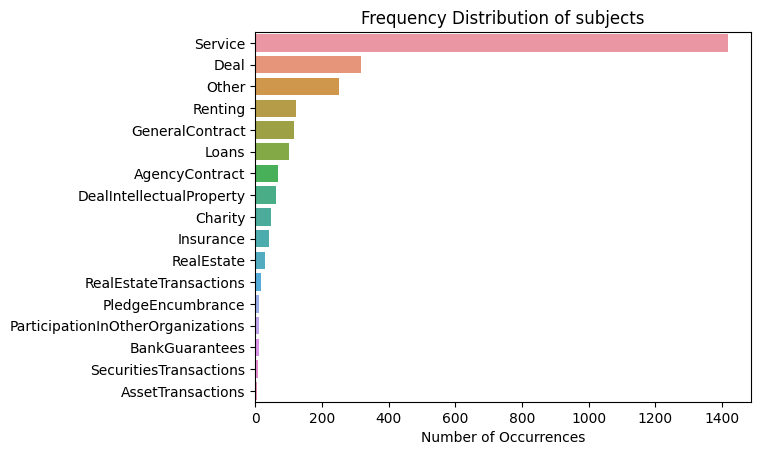


min 4
max 1417
total 2635


In [79]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [80]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['Loans', 'SecuritiesTransactions', 'GeneralContract', 'BankGuarantees', 'Service', 'Charity', 'PledgeEncumbrance', 'AgencyContract', 'Renting', 'Deal', 'DealIntellectualProperty', 'AssetTransactions', 'ParticipationInOtherOrganizations', 'Insurance', 'RealEstateTransactions', 'Other', 'RealEstate']


Service                              0.463051
Deal                                 0.582871
Other                                0.607288
Renting                              0.699489
GeneralContract                      0.704377
Loans                                0.728120
AgencyContract                       0.796387
DealIntellectualProperty             0.811067
Charity                              0.863442
Insurance                            0.893428
RealEstate                           0.987994
RealEstateTransactions               1.186060
PledgeEncumbrance                    1.310108
ParticipationInOtherOrganizations    1.310108
BankGuarantees                       1.352309
SecuritiesTransactions               1.615992
AssetTransactions                    2.087910
Name: subject, dtype: float64

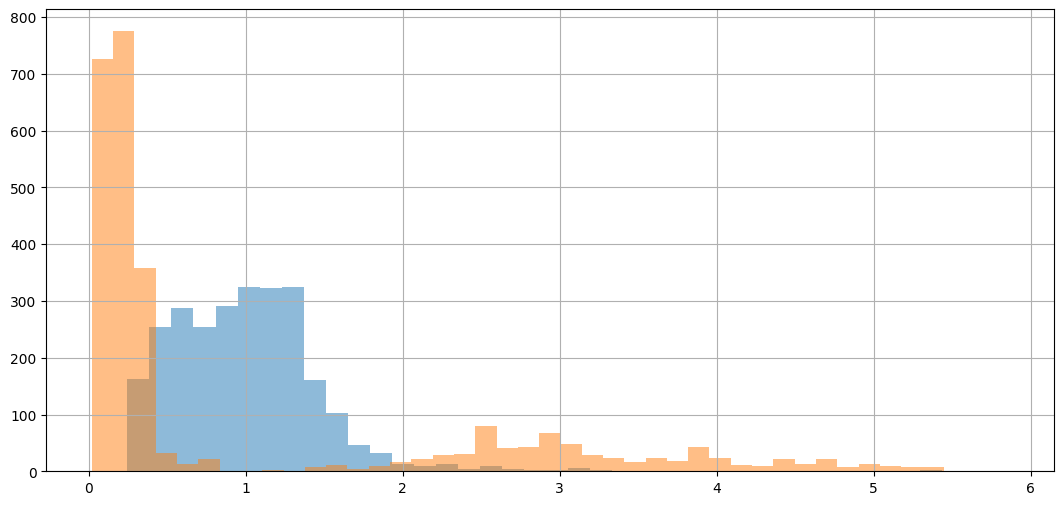

In [81]:
from trainsets.trainset_tools import get_feature_log_weights
 

plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

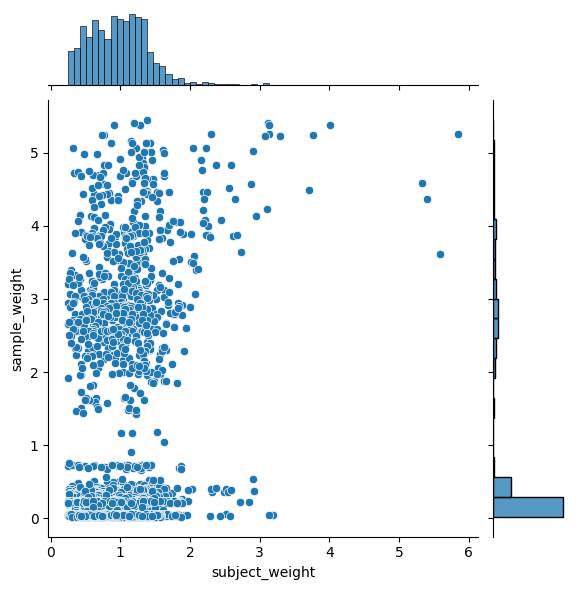

In [82]:
sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()

# look into trainset (take a sample)

SAMPLE_DOC_ID 6285f9c04d1bfe5e5b297ddd
semantic map shape is: (5556, 30)


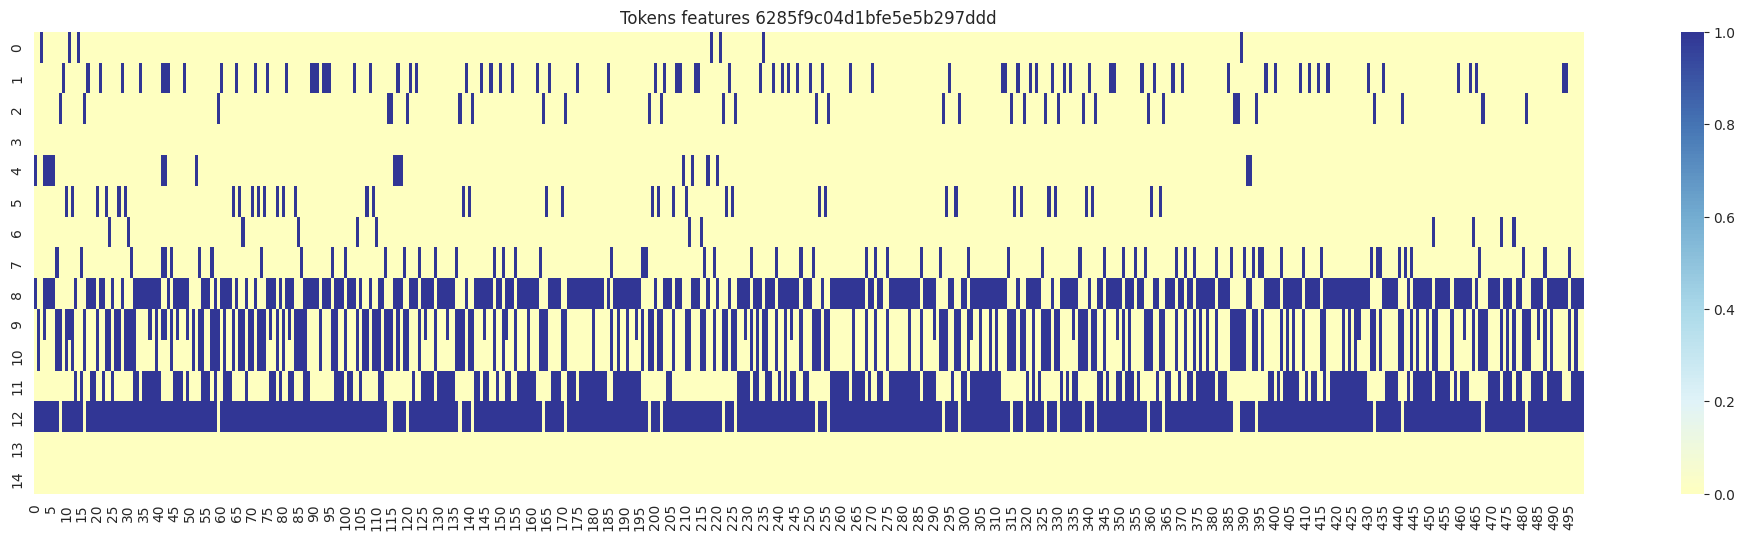

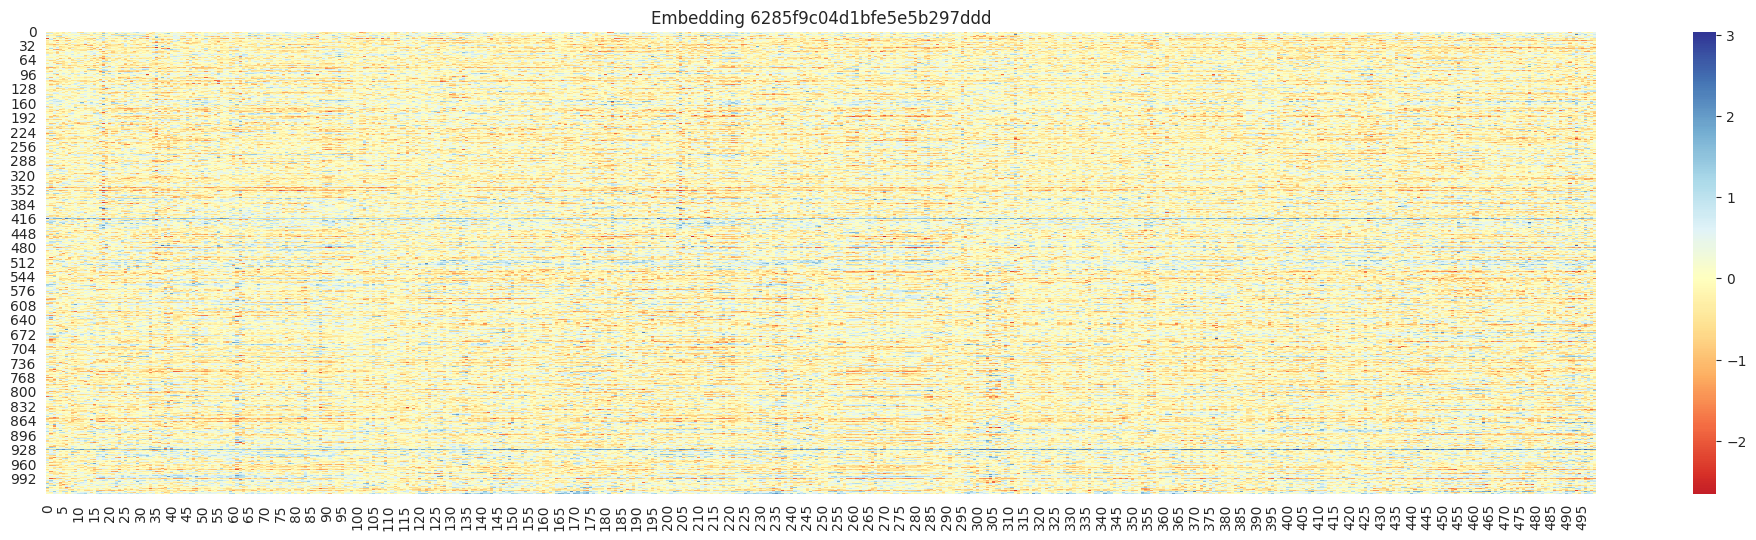

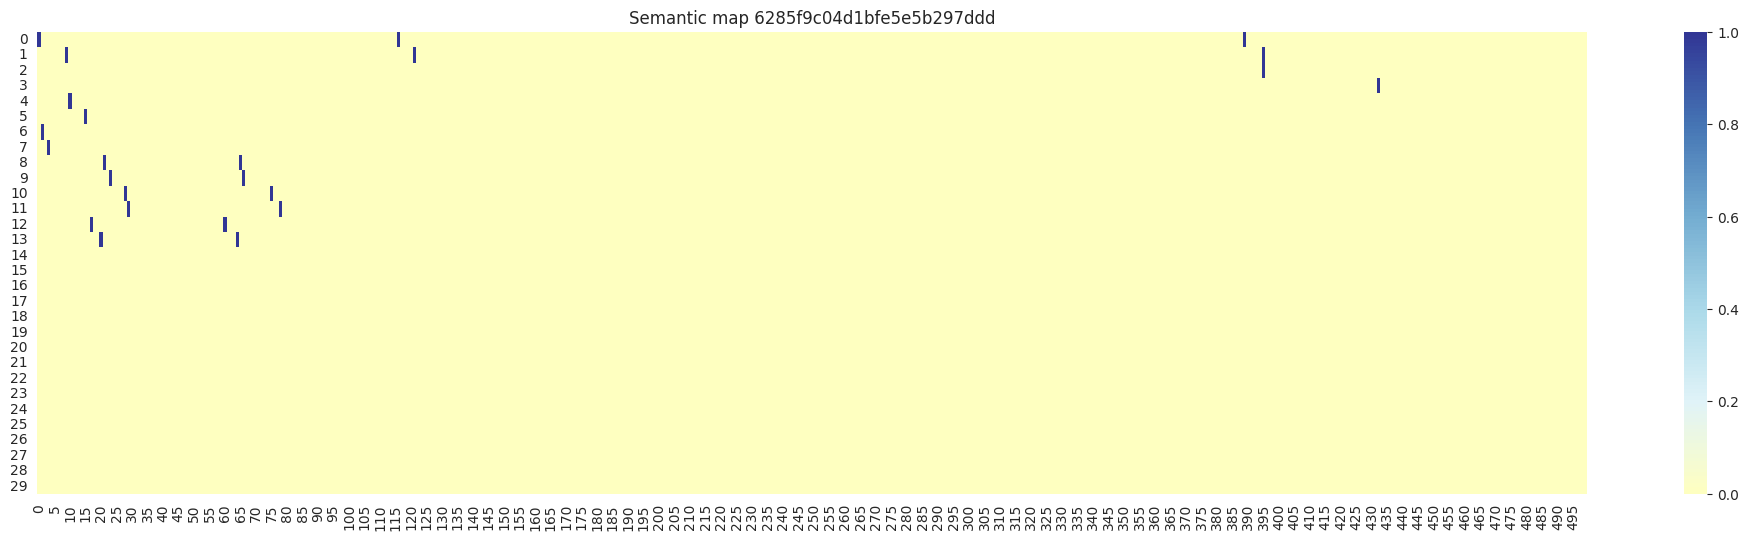

In [83]:
%matplotlib inline
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = stats_valid.index[1]

print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

In [84]:
stats_valid = stats_valid[stats_valid.documentType != 'ANNEX']

3
semantic map shape is: (14, 1003, 30)


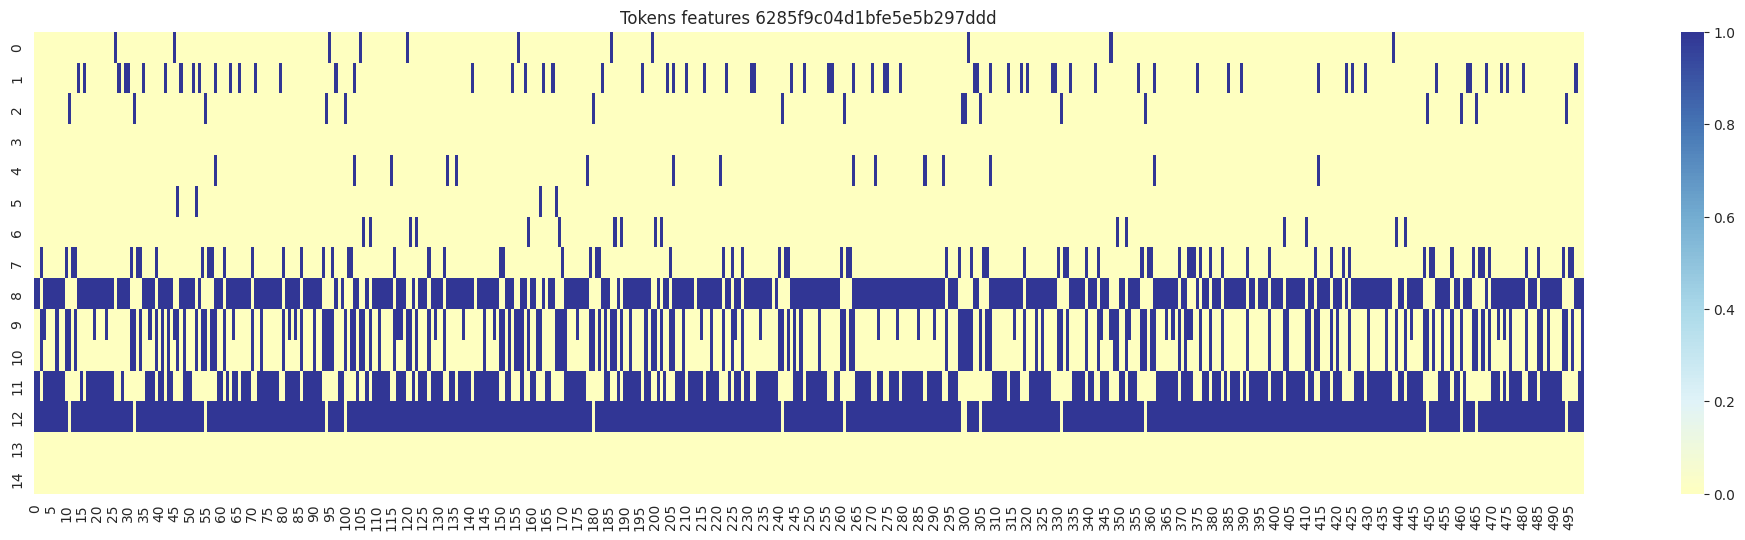

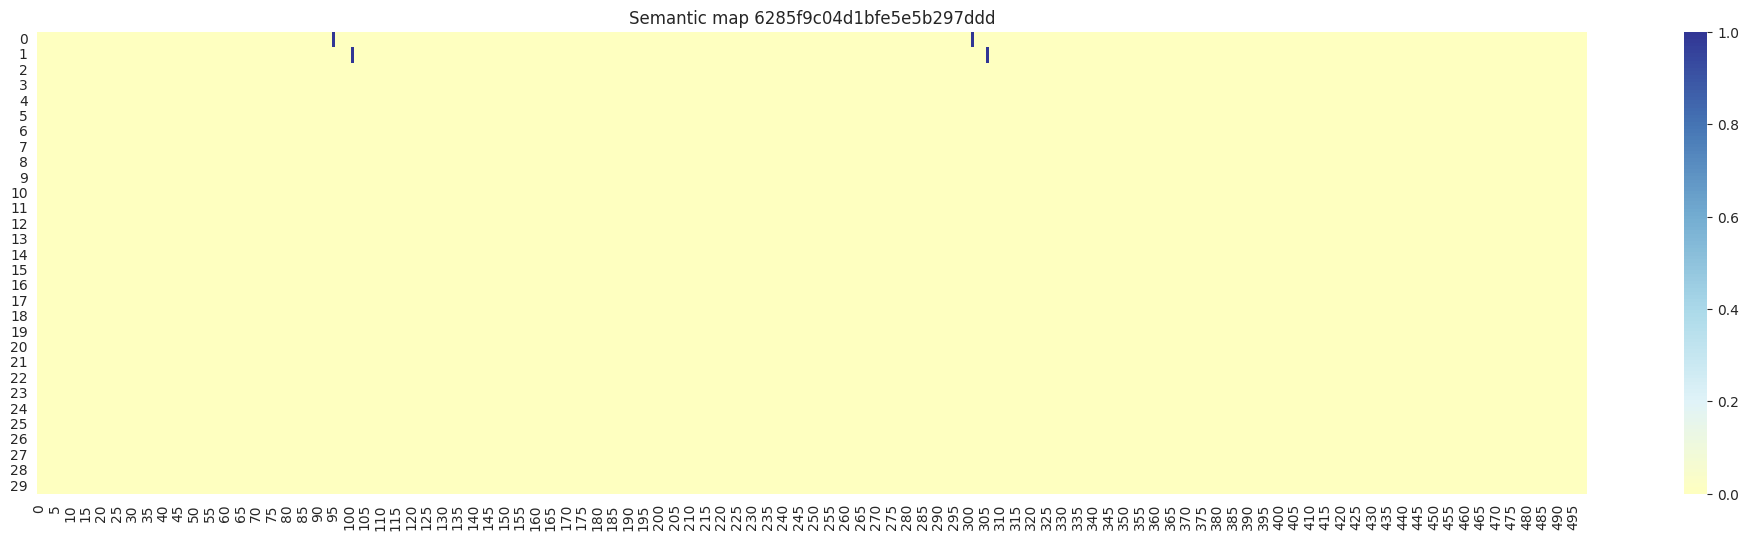

In [85]:
import numpy as np
import random
import pandas as pd

def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
        
#       print(dp)
    
      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        row = stats_valid.loc[doc_id]
        if random.random() < 0.4:  # 40% of samples
          segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center
          if not pd.isna(row['value_span']) and random.random() < 0.7:
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value
        
      dp = self.trim_maxlen(dp, start_from, max_len)
      
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
#       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()
      
      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
#     print('batch_output_subj', len(batch_output_subj))
#     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=0.10, stratify=stats_valid[['subject']])

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, 14, augment_samples=True)

sample = next(_gen)
print(len(sample))
del _gen
 


(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[0][:_crop],    title=f'Semantic map {SAMPLE_DOC_ID}')

train_indices[0]: 5fca2aac9083b679224c7602
test_indices[0]: 638085b16a07f3e980b2c7dc


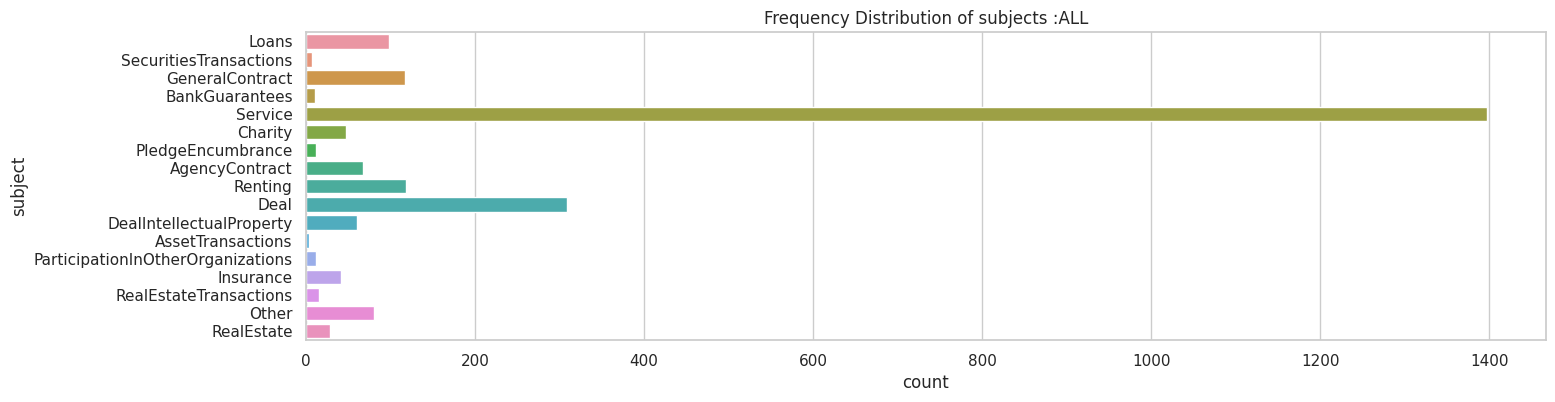

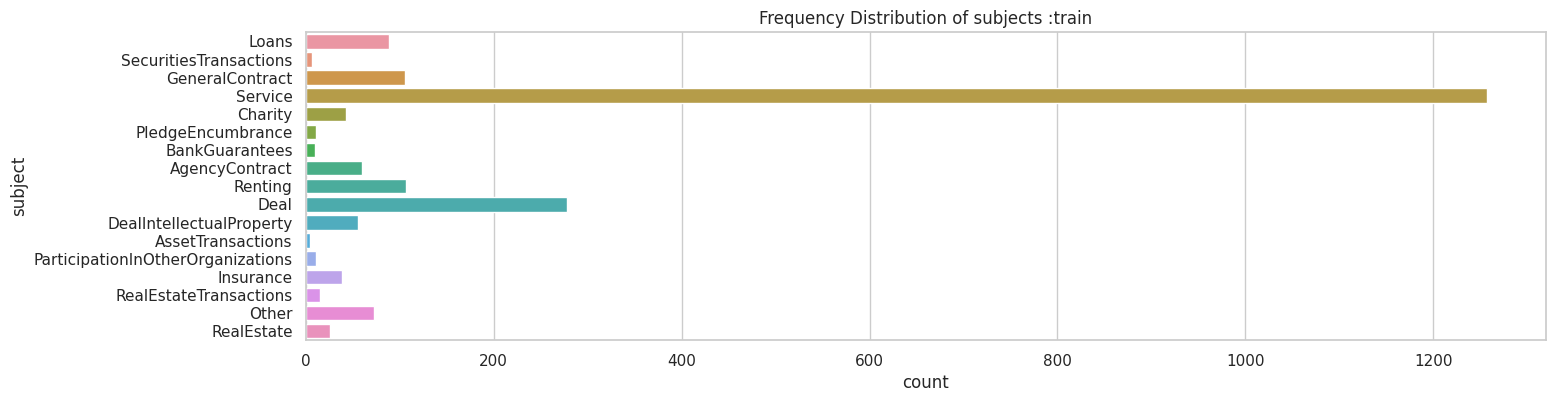

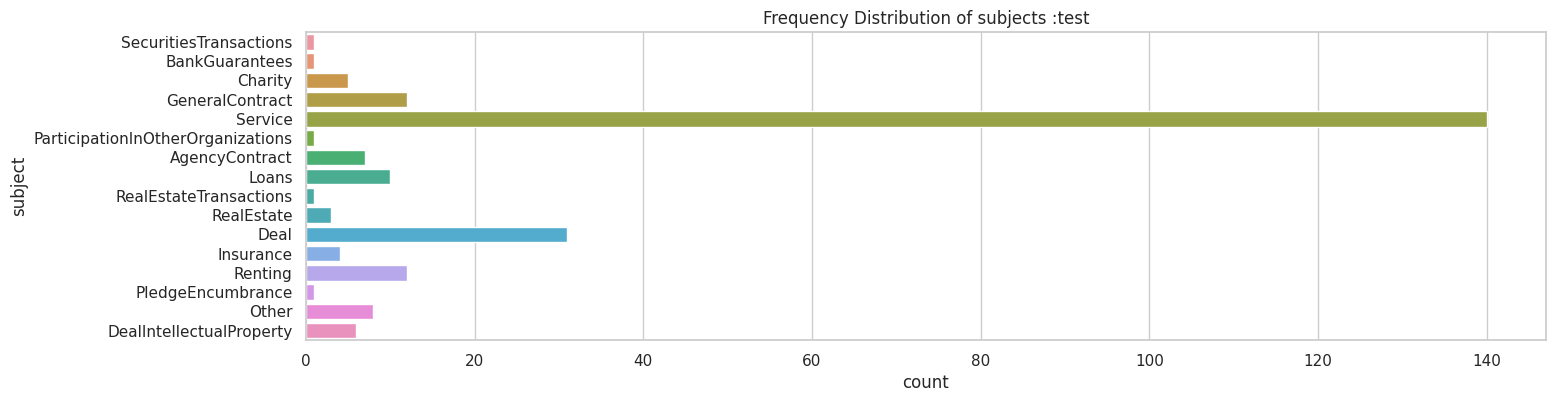

In [86]:
EPOCHS = 50
BATCH_SIZE = 128
EMB =  1024
 
_SELFTEST = True


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [87]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	128
train_samples:	8748
test_samples:	243
steps_per_epoch:	68
validation_steps:	34


# Models 🦖

In [ ]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

## Train from 0 uber_detection_model_003

In [ ]:
if TRAIN_MODEL_3:
    from tf_support.super_contract_model import uber_detection_model_003
    
    model_factory_fn = uber_detection_model_003
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Continue training 003 from checkpoint

In [ ]:
analyser.hyperparams.models_path

In [ ]:
if TRAIN_MODEL_3:
    
    model_factory_fn = uber_detection_model_003

    weights = get_weights_filename(model_factory_fn)
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 25
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Overtrain 003

In [ ]:
if TRAIN_MODEL_3:
    if TRAIN:
      ctx.unfreezeModel(umodel)
      umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
      print(super_contract_model.losses)
      umodel.summary()

      ctx.EPOCHS = 12
      ctx.EVALUATE_ONLY = False

      test_gen = make_generator(umtm, train_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

## uber_detection_model_005
- 0.0233: last val subject loss
- 0.0016: last tagging loss
- 0.0248: last val loss


In [ ]:
if TRAIN_MODEL_3:
    model_factory_fn = uber_detection_model_005_1_1
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 2
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [ ]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 



model_factory_fn = uber_detection_model_005_1_1
weights = get_weights_filename(model_factory_fn)
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

In [ ]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################

if TRAIN:
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

  ctx.EPOCHS = 10
  ctx.EVALUATE_ONLY = False
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

#### Phase II finetuning
all unfrozen, entire trainset, low LR
 

In [ ]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
  umodel.summary()
  
  ctx.EPOCHS = 12
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=1e-6)

# Evaluate models

In [88]:
# def save_checkpoint(ctx, model_factory_fn):
    
#     model_name = model_factory_fn.__name__    
#     model = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.weights')
#     model.summary()    


#     ch_fn = os.path.join(ctx.model_checkpoint_path, f"{model_name}-{keras.__version__}.h5")

#     if not os.path.isfile(ch_fn):
#       model.save_weights(ch_fn)
#       print(f"model weights saved to {ch_fn}")

#     else:
#       print(f"model weights NOT saved, because file exists {ch_fn}")

# save_checkpoint(ctx, uber_detection_model_005_1_1)

In [89]:
# /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5

#######################################
#######################################
model_fn = uber_detection_model_005_1_1
# model_fn = uber_detection_model_003
#######################################
#######################################

umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')

#TODO: remove next 2 lines
ctx.trained_models[umodel.name] = umodel.name
models = ctx.trained_models

2023-01-27 08:52:52.262668: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 08:52:52.275290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 08:52:52.277221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-27 08:52:52.277545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there

### training history

loading training log from /root/artem/analyser/training_reports/uber_detection_model_005_1_1.1.log.csv


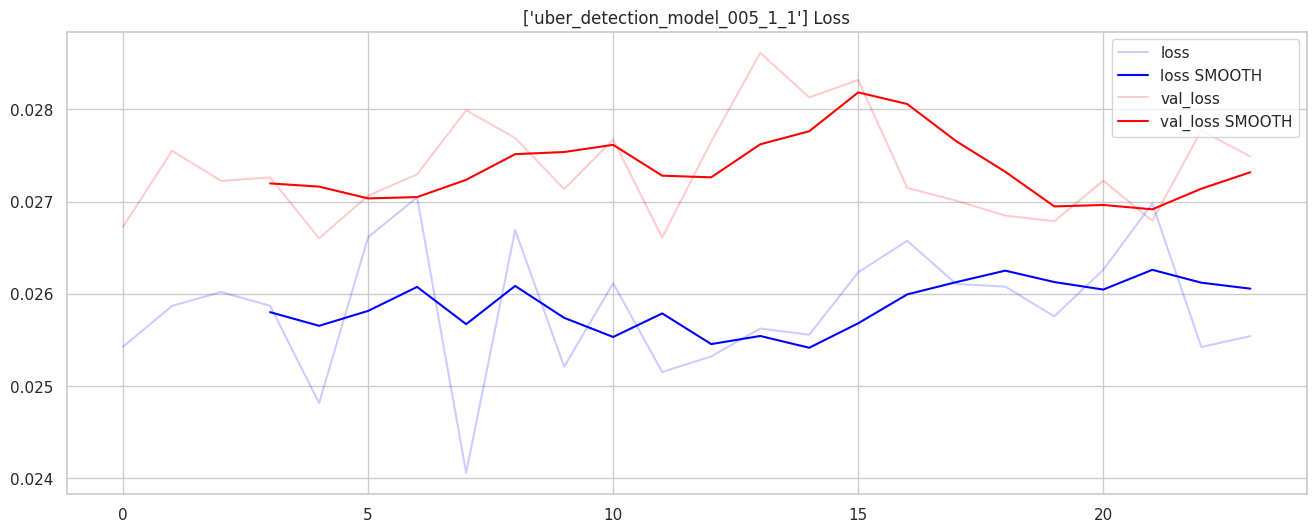

loading training log from /root/artem/analyser/training_reports/uber_detection_model_005_1_1.1.log.csv


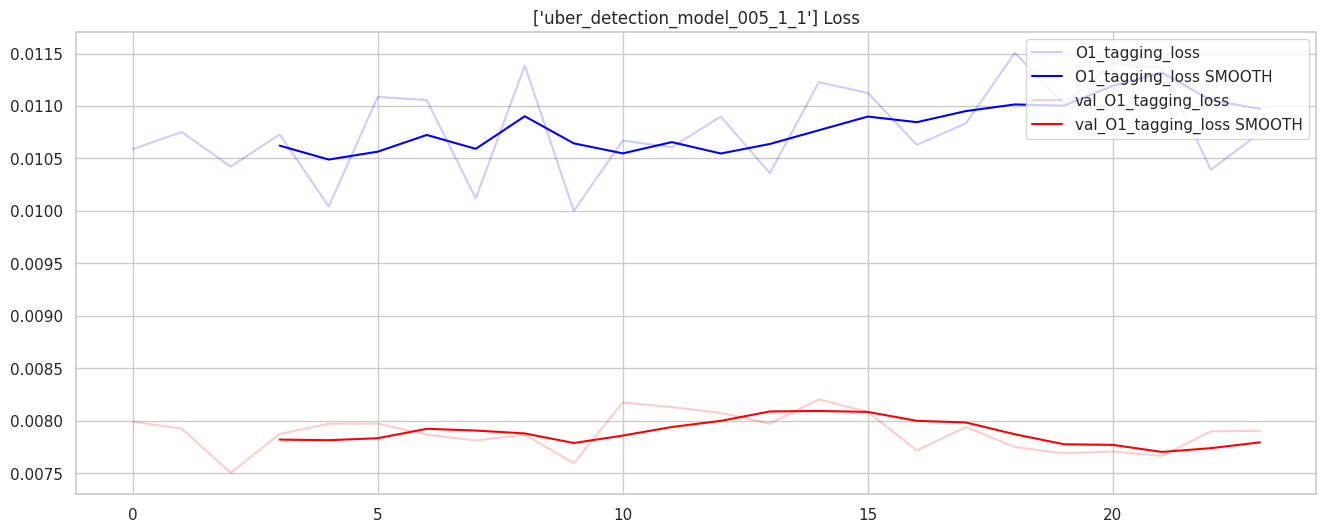

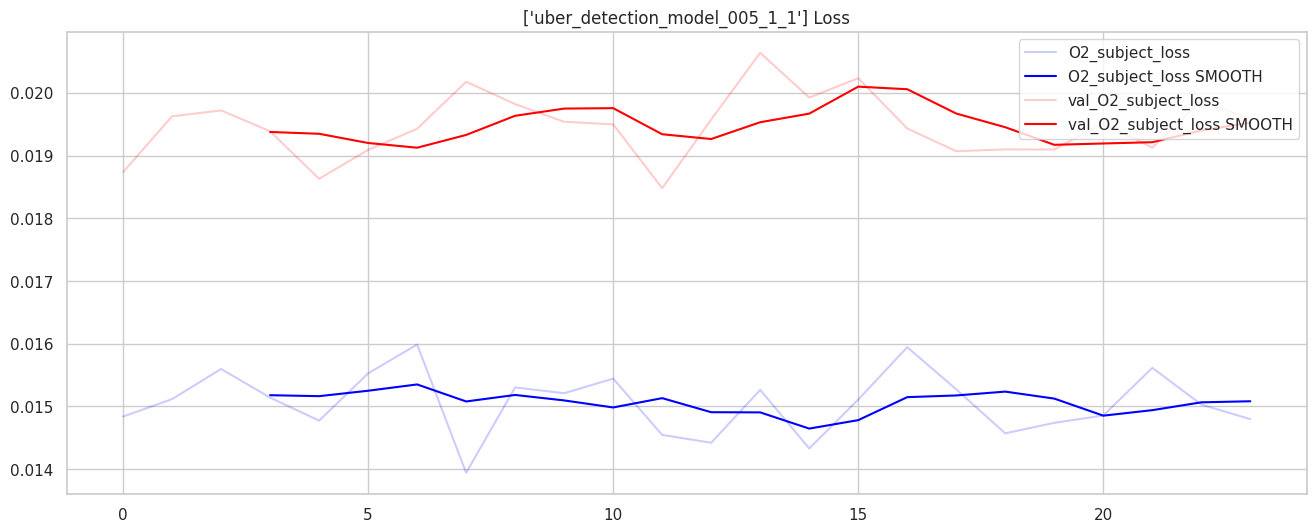

In [90]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.reports_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

# plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
# plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
# plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
# plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')



## Contract subj Confusion matrices

In [ ]:
# umtm.stats
# semantic_map_keys_contract


In [ ]:
from tf_support.super_contract_model import make_xyw

sample_index = umtm.stats [umtm.stats['value']>0].index[2]
print(sample_index)

x, y, _ = make_xyw(sample_index, umtm.stats)

prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
# .T
plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

In [ ]:
from analyser.contract_parser import nn_get_tag_values

In [ ]:

agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]

# seq_labels_contract[-3:]

tagnames = solo_tags + agent_tags


from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
# from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

from analyser.contract_parser import nn_find_org_names, nn_get_tag_value




def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = nn_get_tag_value(key, _map, tagsmap )
    results[key] = t
    # print(t)

#   ca = ContractAgent()
#   ca.name =  results['org-1-name'] #TODO: check for NONE
#   ca.type =  results['org-1-type']
#   ca.alias = results['org-1-alias']
   

#   ca2 = ContractAgent()
#   ca2.name =  results['org-2-name'] #TODO: check for NONE
#   ca2.type =  results['org-2-type']
#   ca2.alias = results['org-2-alias']
#   try:
#     normalize_contract_agent(ca)
#     normalize_contract_agent(ca2)
#   except Exception as e:
#         # TODO:
#     logger.error(f'{_id} {e}')

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]



In [ ]:
def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    
    x, y, _ = make_xyw(_id, umtm.stats)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
  
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)
    

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags

ev, tags = make_subj_predictions(umodel, [sample_index])
tags

In [ ]:
%%time




# def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
#   att = tagging[tagname].values
#   slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
#   if len(slices) > 0:
#     span = slices[0].start, slices[0].stop
#     value = textmap.text_range(span)
#     tag = SemanticTag(tagname, value, span)
#     tag.confidence = att[slices[0]].mean()
#     return tag
#   return None










subset = umtm.stats #umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
_indices =  subset.index
ev, tags = make_subj_predictions(umodel, _indices)
tags.to_csv('all_contracts_predicstions.csv')

In [ ]:
# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])]
# pd.isna(umtm.stats['user_correction_date'])
ev 

In [ ]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

ev['predicted_subj']
subj_df = ev[['predicted_subj', 'expected_subj']].copy()

In [ ]:
subj_df

In [ ]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


subj_df = ev[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

# Evaluate tags detection

In [ ]:
tags.fillna('-', inplace=True)
tags

In [ ]:
def save_csv(d, f):
    fn = os.path.join(umtm.work_dir, f)
    d.to_csv(fn)

### Contract number validation

In [ ]:
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
print( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags) :0.1f}%) were detected wronggly')

save_csv( wrong_numbers[['p-number', 'number']], 'wrong_numbers.csv')

# wrong_numbers[['p-number', 'number']].tail(10)

In [ ]:
tags ['sign_value_currency/currency'].head(100)

In [ ]:
def conv(x):
    if type(x) is str:
        v = x.replace(',','.').replace(' ','')
    else: 
        v=x
    try:
        v=float(v)
    except:
        v=np.nan
    return v 

tags['n-p-sign_value_currency/value'] = pd.to_numeric( tags['p-sign_value_currency/value'].apply(conv) )
tags['n-sign_value_currency/value']   = pd.to_numeric( tags['sign_value_currency/value'].apply(conv) )

In [ ]:
wrong_values = tags [  tags['n-p-sign_value_currency/value']  != tags['n-sign_value_currency/value']]
cols = ['n-p-sign_value_currency/value', 'n-sign_value_currency/value']
wrong_values = wrong_values[cols]

wrong_values ['val_err'] = \
    np.log1p( np.abs(wrong_values['n-p-sign_value_currency/value'] - wrong_values['n-sign_value_currency/value']))
wrong_values = wrong_values.sort_values('val_err', ascending=False)

print(len(wrong_values))
wrong_values.tail(24)

### Contract Org-1 validation

In [ ]:


wrong_orgs1 = tags [ (tags['org-1-name'] != tags['p-org-1-name']) | (tags['org-2-name'] != tags['p-org-2-name']) ]
print( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags):0.1f}%) were detected incorrectly')

cols=['p-org-1-name', 'org-1-name', 'p-org-2-name', 'org-2-name']
save_csv( wrong_orgs1[cols], 'wrong_orgs1.csv')

wrong_orgs1[cols].head(20)

In [ ]:
wrong_aliases = tags [ (tags['org-1-alias'] != tags['p-org-1-alias']) | (tags['org-2-alias'] != tags['p-org-2-alias']) ]
print( f'Aliases: {len(wrong_aliases)} of {len(tags)}  ({100. * len(wrong_aliases) / len(tags) : 0.1f}%) were detected incorrectly')

cols=['p-org-1-alias', 'org-1-alias', 'p-org-2-alias', 'org-2-alias']
save_csv( wrong_aliases[cols], 'wrong_aliases.csv')
# wrong_aliases[cols].head(10)

In [ ]:
wrong_types = tags [ (tags['org-1-type'] != tags['p-org-1-type']) | (tags['org-2-type'] != tags['p-org-2-type'])]
print( f'Types: {len(wrong_types)} of {len(tags)}  ({100. * len(wrong_types) / len(tags) : 0.1f}%) were detected incorrectly')
cols=['p-org-1-type', 'p-org-2-type', 'org-1-type', 'org-2-type']
save_csv( wrong_types[cols], 'wrong_types.csv')
wrong_types[cols].head(10)

In [ ]:
from collections import Counter
arrays = [ wrong_orgs1, wrong_types, wrong_numbers, wrong_aliases]
counter = Counter()
for a in arrays:
  for i in a.index:
   counter[i]+=1
 

print('Самый сложный документ: ', counter.most_common()[0][0])
print("Всего недочетов:", len(counter))

In [ ]:
umtm.stats['errors'] = 0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
    
    
    
  SAMPLE_DOC_ID = '5eea27adc28b75807f3dae66'
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:

# mean_ = tagging.values.max(-1)*0.5
# print (mean_.shape)
# display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:24000],  mean_[:24000])))

In [ ]:
ids = '5edbadd7da3678279fbcaabf
5edbc660da3678279fbcaeac
5edbc668da3678279fbcaf6e
5edbc65dda3678279fbcae56
5edbc66bda3678279fbcafe6
5edbc615da3678279fbcadc9'